In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{gensymb} \usepackage{siunitx}'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

### Loading the dataset

In [2]:
DATASET_PATH = '../datasets/dataset_NEMA3_impulse.csv'

In [3]:
from rc_dataset_impulse_cnwheat import ExperimentDataset

dataset = ExperimentDataset(csv_path=DATASET_PATH)

### Figure

In [48]:
def nmse_distance(baseline, impulse):
  dist = np.empty(len(baseline))
  norm_factor = (baseline.var(axis=0) + 1e-12)
  for i_step in range(len(baseline)):
    base_state = baseline[i_step]
    state = impulse[i_step]
    dist[i_step] = ((base_state - state)**2 / norm_factor).mean()
  return dist


def get_data(run1, run2, state):
  # get raw data
  data1 = dataset.get_state(state, run1)[START:STOP]
  data2 = dataset.get_state(state, run2)[START:STOP]
  # remove NaN values
  NaN = np.isnan(data1)
  NaN_idx = np.any(NaN, axis=0)
  data1 = data1[:, ~NaN_idx]
  data2 = data2[:, ~NaN_idx]
  # calculate divergence between reservoir runs
  divergence = nmse_distance(data1, data2)
  return divergence

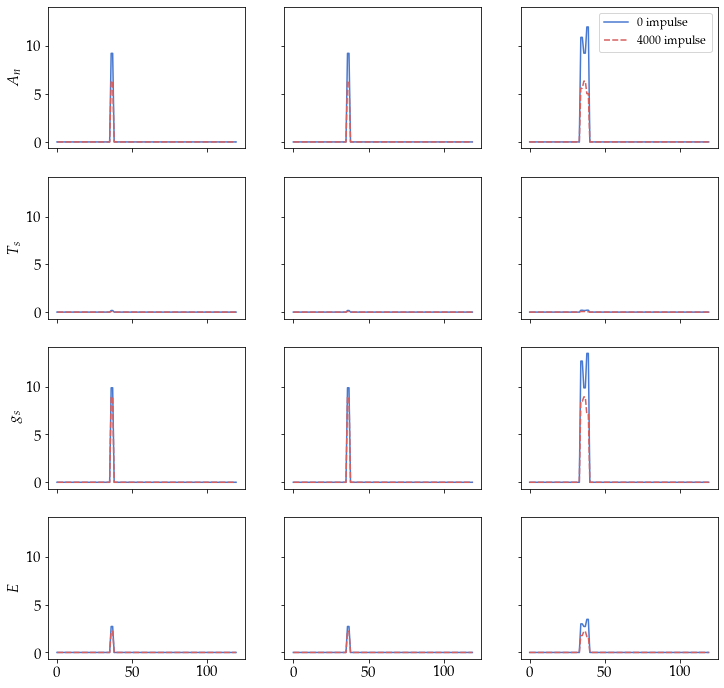

In [38]:
reservoirs = [
  'state__An',
  'state__Ts',
  'state__gs',
  'state__Transpiration', 
]

symbols = {
  'state__An': r'$A_n$',
  'state__Ts': r'$T_s$',
  'state__gs': r'$g_s$',
  'state__Transpiration': r'$E$',
}

widths = [1, 3, 5]

baseline = 'NEMA_H3__day0__width0__0'
template = lambda width, value: f'NEMA_H3__day18__width{width}__{value}'

START = (19 - 2) * 24
STOP = START + 5 * 24



with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(len(reservoirs), len(widths), figsize=(12, 12), sharex=True, sharey=True)
  colors = sns.color_palette()
  plot_colors = colors[0], colors[2]

  for (state, axs_row) in zip(reservoirs, axs):
    for (width, ax) in zip(widths, axs_row):
      # get data
      pulse_lo = get_data(baseline, template(width, 0), state)
      pulse_hi = get_data(baseline, template(width, 4000), state)
      df = pd.DataFrame(pulse_lo, pulse_hi).reset_index()
      df.columns = ['0 impulse', '4000 impulse']

      # plot data
      sns.lineplot(data=df, ax=ax, palette=plot_colors)

      # x axis
      xticks = np.arange(START, STOP + 1)

      # y axis
      ax.set_ylabel(symbols[state])

      # cleanup
      if ax is not axs[0][-1]:
        ax.get_legend().remove()


In [45]:
print(get_data)

<function get_data at 0x000001DDB3F994C0>


In [47]:
import inspect
lines = inspect.getsource(get_data)
print(lines)

def get_data(run1, run2, state):
  # get raw data
  data1 = dataset.get_state(state, run1)[START:STOP]
  data2 = dataset.get_state(state, run2)[START:STOP]
  # remove NaN values
  NaN = np.isnan(data1)
  NaN_idx = np.any(NaN, axis=0)
  data1 = data1[:, ~NaN_idx]
  data2 = data2[:, ~NaN_idx]
  # calculate divergence between reservoir runs
  divergence = nmse_distance(data1, data2)
  return divergence

